## EfficientNetB0
### Database: [Plant Diseases Training Dataset](https://www.kaggle.com/datasets/nirmalsankalana/plant-diseases-training-dataset/data)

In [63]:
#Import nessesary packages, libraries and global variables

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from  PIL import Image
import numpy as np
from tensorflow.keras import Input, Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import split_dataset
import tensorflow as tf
from tensorflow import keras

import sys
sys.path.append('../modeling')

RSEED = 42
dataset_path = '../data/train/'

In [9]:
#getting impatient

def load_preprocess_split_train_val(data_path):
    ''' 
    Function needs filefath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image = tf.keras.utils.image_dataset_from_directory(
        data_path, 
        validation_split = 0.2,
        subset = "both", 
        seed = RSEED,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical'
    )
    return image 

In [23]:
train_ds, val_ds = load_preprocess_split_train_val(dataset_path)

Found 76697 files belonging to 39 classes.
Using 61358 files for training.
Using 15339 files for validation.


In [24]:
#check an example 
val_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None))>

------------------------------------------------------------------------------------------------------------------------------------------
#### Developing a model
------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
import tensorflow.keras.backend as K
K.clear_session()

In [14]:
#define model

model = keras.applications.EfficientNetB0(
    include_top=False
)

In [15]:
#get overview of the model architecture

model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, None, None, 3)        0         ['normalization[0

In [19]:
from keras import layers
IMG_SIZE = 224
BATCH_SIZE = 32

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)) # Define the input layer with the shape of input images
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet") # Load the EfficientNetB0 model pretrained on ImageNet without the top classification layer
                                                                                        # Use the input layer defined above

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output) # Apply global average pooling to the output of the base layers
    x = layers.BatchNormalization()(x) # Apply batch normalization to normalize the activations of the previous layer


    top_dropout_rate = 0.2 # Define the dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x) # Apply dropout regularization to the previous layer
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x) # Add a dense layer for classification with softmax activation

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet") # Construct the final model with the specified input and output layers
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2) # Define the optimizer with a learning rate of 0.01 using the Adam optimizer
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [17]:
model = build_model(num_classes=39)

epochs = 12  # @param {type: "slider", min:8, max:80}
#hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


In [20]:


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

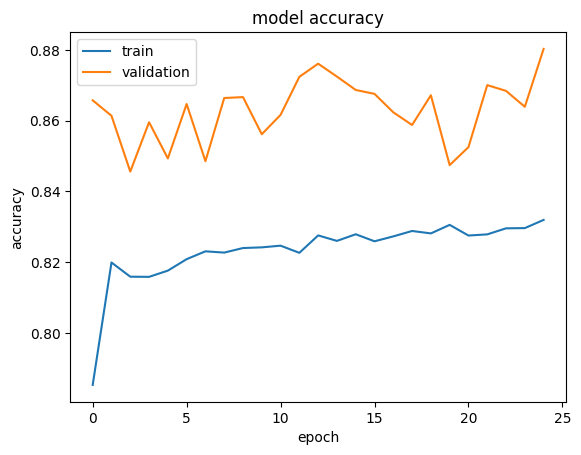

In [14]:
plot_hist(hist)

#### next we want to unfreeze a couple of layers and retrain with own data

In [21]:
#next we want to unfreeze 10 layers and retrain 

import tensorflow as tf

def unfreeze_model_and_clone(model):
    # Clone the original model
    unfrozen_model = tf.keras.models.clone_model(model)
    unfrozen_model.set_weights(model.get_weights())  # Copy weights

    # Unfreeze the top 10 layers while leaving BatchNorm layers frozen
    for layer in unfrozen_model.layers[-10:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    unfrozen_model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return unfrozen_model


Epoch 1/8
1918/1918 [==============================] - 530s 275ms/step - loss: 2.1398 - accuracy: 0.4816 - val_loss: 1.0859 - val_accuracy: 0.7108
Epoch 2/8
1918/1918 [==============================] - 1694s 883ms/step - loss: 1.0449 - accuracy: 0.7128 - val_loss: 0.7107 - val_accuracy: 0.7955
Epoch 3/8
1918/1918 [==============================] - 514s 268ms/step - loss: 0.7646 - accuracy: 0.7786 - val_loss: 0.5569 - val_accuracy: 0.8330
Epoch 4/8
1918/1918 [==============================] - 2495s 1s/step - loss: 0.6295 - accuracy: 0.8136 - val_loss: 0.4742 - val_accuracy: 0.8543
Epoch 5/8
1918/1918 [==============================] - 559s 291ms/step - loss: 0.5442 - accuracy: 0.8357 - val_loss: 0.4236 - val_accuracy: 0.8693
Epoch 6/8
1918/1918 [==============================] - 521s 271ms/step - loss: 0.4897 - accuracy: 0.8495 - val_loss: 0.3864 - val_accuracy: 0.8798
Epoch 7/8
1918/1918 [==============================] - 521s 272ms/step - loss: 0.4475 - accuracy: 0.8593 - val_loss: 0.

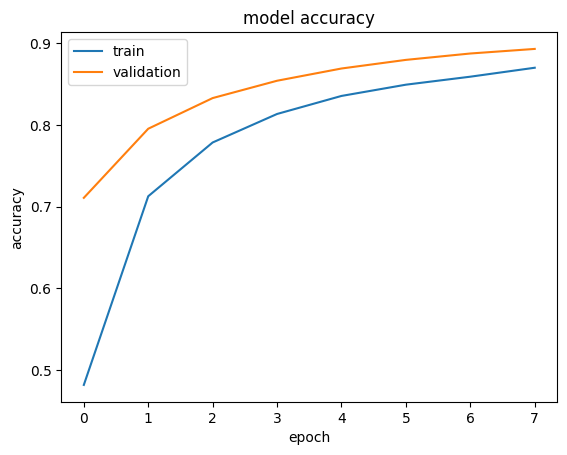

In [33]:
# Create a new model with unfrozen layers
unfrozen_model2 = unfreeze_model_and_clone(model)

epochs = 8
hist = unfrozen_model2.fit(train_ds, epochs=epochs, validation_data=val_ds)

plot_hist(hist)


Epoch 1/12
1918/1918 [==============================] - 569s 294ms/step - loss: 2.2256 - accuracy: 0.4589 - val_loss: 1.1025 - val_accuracy: 0.7070
Epoch 2/12
1918/1918 [==============================] - 593s 309ms/step - loss: 1.0609 - accuracy: 0.7080 - val_loss: 0.7245 - val_accuracy: 0.7952
Epoch 3/12
1918/1918 [==============================] - 616s 321ms/step - loss: 0.7744 - accuracy: 0.7759 - val_loss: 0.5673 - val_accuracy: 0.8312
Epoch 4/12
1918/1918 [==============================] - 598s 312ms/step - loss: 0.6330 - accuracy: 0.8108 - val_loss: 0.4818 - val_accuracy: 0.8518
Epoch 5/12
1918/1918 [==============================] - 587s 306ms/step - loss: 0.5493 - accuracy: 0.8320 - val_loss: 0.4296 - val_accuracy: 0.8648
Epoch 6/12
1918/1918 [==============================] - 597s 311ms/step - loss: 0.4925 - accuracy: 0.8480 - val_loss: 0.3906 - val_accuracy: 0.8753
Epoch 7/12
1918/1918 [==============================] - 601s 313ms/step - loss: 0.4480 - accuracy: 0.8598 - val_

/Users/freyasteinhagen/neue_fische/AgronomiCare/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


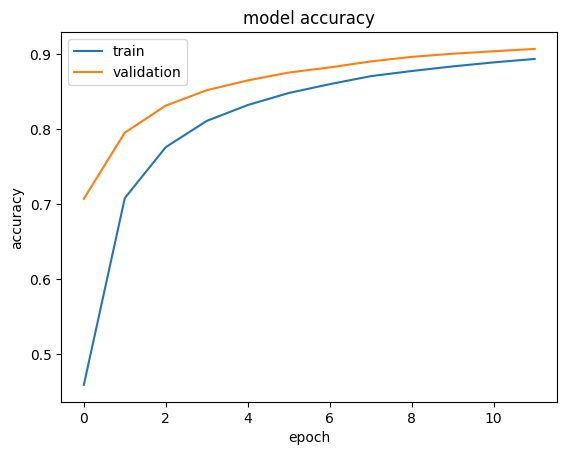

In [27]:
# Create a new model with unfrozen layers
unfrozen_model3 = unfreeze_model_and_clone(model)

epochs = 12
hist3 = unfrozen_model3.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the model to disk
unfrozen_model3.save("unfrozen_model3.h5")

plot_hist(hist3)

In [28]:
# Save the trained model to the specified directory
model_dir = "../models/"
model_filename = "efficient_unfrozen_12.h5"
unfrozen_model3.save(os.path.join(model_dir, model_filename))

# You can load it back with keras.models.load_model().

------------------------------------------------------------------------------------------------------------------------------------------
#### Testing of the model with unseen data
------------------------------------------------------------------------------------------------------------------------------------------

In [70]:


def load_test(data_path):
    ''' 
    Function needs filepath as parameter, it will create a validation dataset of 20% of the total df, 
    Needs an RSEED as global variable,
    Image will be cropped to 1:1 and altered to 224 x 224
    '''
    image_dataset = tf.keras.utils.image_dataset_from_directory(
        data_path,
        image_size = (224, 224),
        crop_to_aspect_ratio = True,
        label_mode = 'categorical',
        shuffle = False
    )
    return image_dataset 

In [71]:
dataset_test_path = '../data/test/'

test_ds = load_test(dataset_test_path)

Found 19174 files belonging to 39 classes.


In [72]:
#check an example 
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 39), dtype=tf.float32, name=None))>

In [73]:
# Make predictions on the test dataset
predictions = unfrozen_model3.predict(test_ds)

600/600 [==============================] - 126s 210ms/step


------------------------------------------------------------------------------------------------------------------------------------------
#### Plotting the results and getting evaluation metrics
------------------------------------------------------------------------------------------------------------------------------------------

In [74]:
'''# Get the true labels from the file paths
true_labels = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    true_labels.append(label)

# Create a list of unique classes
classes = sorted(set(true_labels))

# Create a mapping from class names to indices
class_to_index = {cls: i for i, cls in enumerate(classes)}

# Convert true labels to indices
true_labels_indices = [class_to_index[label] for label in true_labels]

# Convert predicted classes to their corresponding class names
predicted_classes_labels = [classes[pred] for pred in predicted_classes]
'''


In [75]:
'''# Generate classification report
report = classification_report(true_labels, predicted_classes_labels)
# Display the classification report
print("Classification Report:")
print(report)'''

Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.00      0.00      0.00        64
    bacterial_blight       0.03      0.02      0.03       584
      bacterial_spot       0.06      0.06      0.06      1157
      bacterial_wilt       0.02      0.02      0.02       113
       black_measles       0.02      0.02      0.02       449
           black_rot       0.02      0.02      0.02       384
               blast       0.03      0.03      0.03       303
          brown_spot       0.03      0.03      0.03       341
brown_streak_disease       0.02      0.02      0.02       451
     citrus_greening       0.05      0.05      0.05      1183
         common_rust       0.00      0.00      0.00       224
        early_blight       0.04      0.03      0.03       656
      gray_leaf_spot       0.00      0.00      0.00        98
           gray_spot       0.01      0.01      0.01        76
        green_mottle       0.03      0.02     

In [76]:
'''from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(true_labels_indices, predicted_classes , normalize='pred')
# Display the confusion matrix
print("Confusion Matrix:")
print(cm)'''


Confusion Matrix:
[[0.         0.00394477 0.00172712 ... 0.         0.00869565 0.        ]
 [0.05       0.02761341 0.02763385 ... 0.04926108 0.0173913  0.04237288]
 [0.06666667 0.06311637 0.06044905 ... 0.06403941 0.04347826 0.06779661]
 ...
 [0.         0.01775148 0.01295337 ... 0.00492611 0.         0.02542373]
 [0.         0.00591716 0.00259067 ... 0.         0.02608696 0.00847458]
 [0.01666667 0.00788955 0.00259067 ... 0.         0.         0.00847458]]


In [82]:
# Step 1: Get the true labels from the test dataset
y_true = []
for filepath in test_ds.file_paths:
    label = os.path.basename(os.path.dirname(filepath))
    y_true.append(label)

# Extract unique class labels from your training data
classes = sorted(set(y_true))

# Step 2: Convert true labels to indices using the same mapping used during training
class_to_index = {cls: i for i, cls in enumerate(classes)}
y_true_indices = np.array([class_to_index[label] for label in y_true])

# Step 3: Use your model to make predictions on the test dataset
y_pred_probabilities = unfrozen_model3.predict(test_ds)

# Step 4: Convert the predicted class probabilities to class labels
y_pred_indices = np.argmax(y_pred_probabilities, axis=1)
y_pred = [classes[i] for i in y_pred_indices]

# Step 5: Generate the classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

600/600 [==============================] - 127s 212ms/step
Classification Report:
                      precision    recall  f1-score   support

alternaria_leaf_spot       0.93      0.88      0.90        64
    bacterial_blight       0.86      0.75      0.80       584
      bacterial_spot       0.96      0.96      0.96      1157
      bacterial_wilt       0.85      0.82      0.83       113
       black_measles       0.95      0.97      0.96       449
           black_rot       0.97      0.97      0.97       384
               blast       0.98      0.99      0.99       303
          brown_spot       0.99      0.98      0.98       341
brown_streak_disease       0.58      0.59      0.59       451
     citrus_greening       1.00      1.00      1.00      1183
         common_rust       1.00      1.00      1.00       224
        early_blight       0.95      0.87      0.91       656
      gray_leaf_spot       0.86      0.82      0.84        98
           gray_spot       0.83      0.79      0.

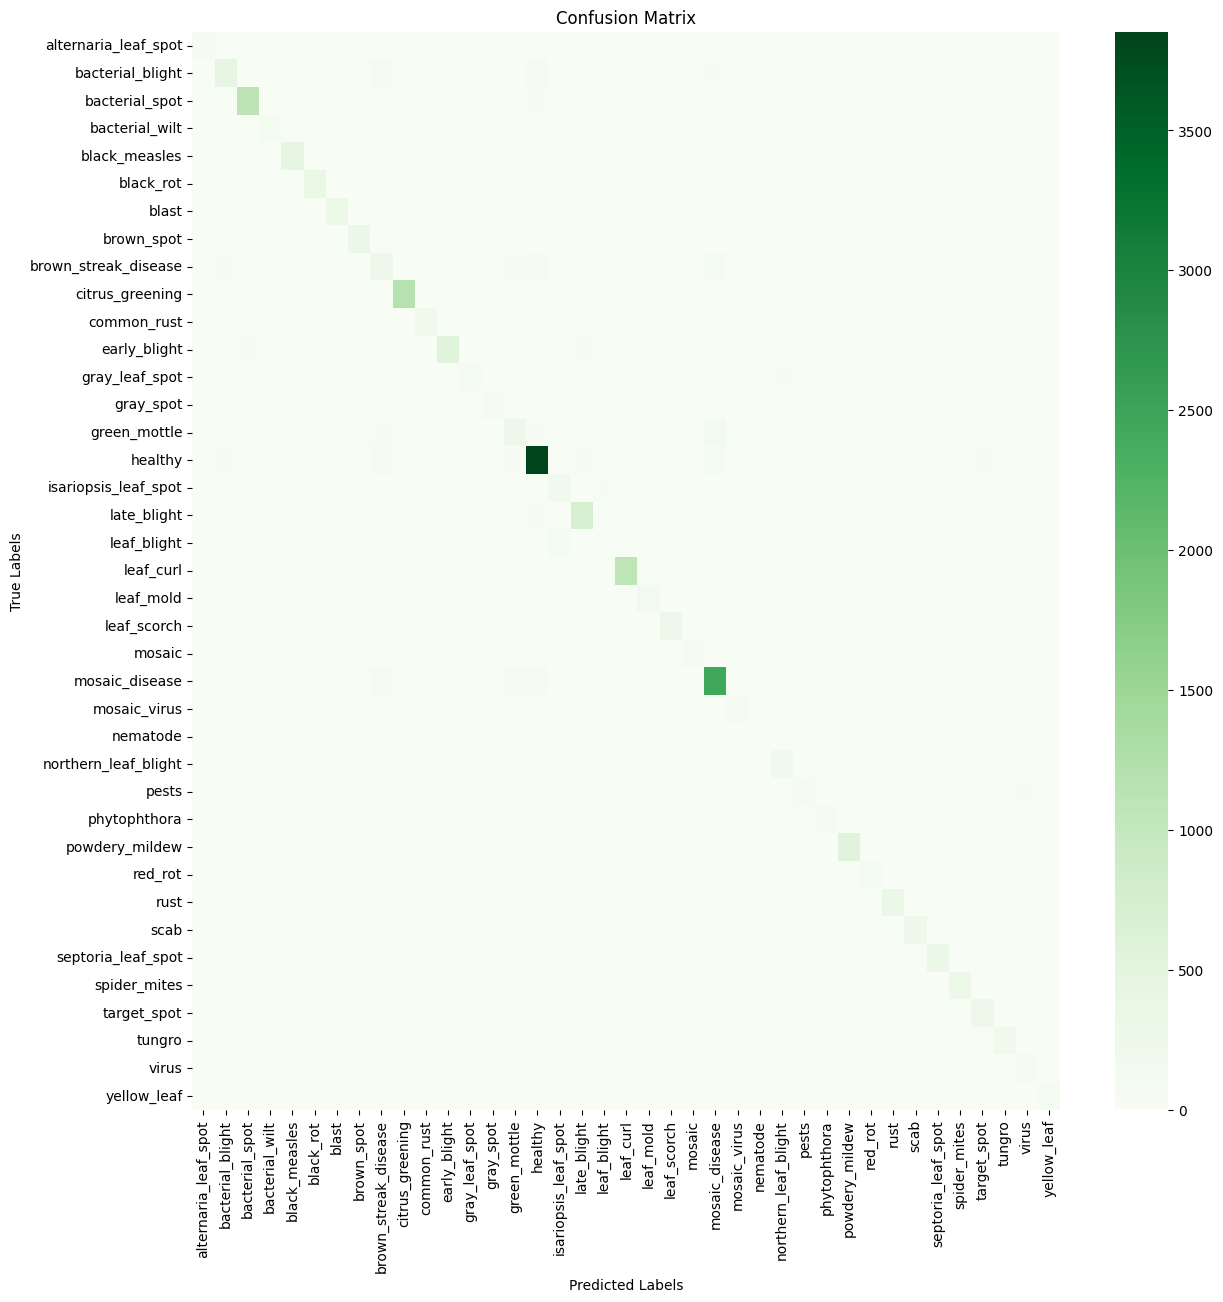

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using seaborn heatmap with green color palette
plt.figure(figsize=(14, 14))
sns.heatmap(cm, annot=False, cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### Next we should try with the suffle parameter turned on (while loarding)